# U-Net testing on [Oxford pet dataset][1]
#### This notebook contains the code assembled from [paperspace.com][2]

[1]: https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset
[2]: https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/

## General Workflow
- [Libraries](#library-imports)
- [Assembling the model](#assemble-the-model)
- [Image imports and plotting](#Data-importing-and-plotting-the-images)
- [Image pre-processing](#Process-the-images)
- [Training](#Test-the-model)
- [Testing](#Test-the-model)

### Library imports

In [2]:
## Library imports
import os
import PIL
import random
import numpy as np
import tensorflow as tf 


# import the necessary packages
from PIL import ImageOps
from tensorflow import keras
from IPython.display import Image, display
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate


### Assemble the Model

#### Define the double convolution block

In [3]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first convolution block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second convolution block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

#### Define the encoder blocks for the encoder path in the U-net

In [6]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

#### Define the decoder blocks for the decoder path in the U-net

In [5]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

#### Assemble the encoder and decoder units into the U-net
_Note:_
-  The skip connections will contain the output of the encoder blocks; which will be concatenated and used as a input to the corresponding decoder block.
-  Remeber to add the bridge between encoder and decoder paths.

In [7]:
## assemble the model
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

#### specify the input parameters

In [2]:
## specify input parameters (adjust the shaped according to your image shapes)
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.summary()

#### Plot the model to check the architecture

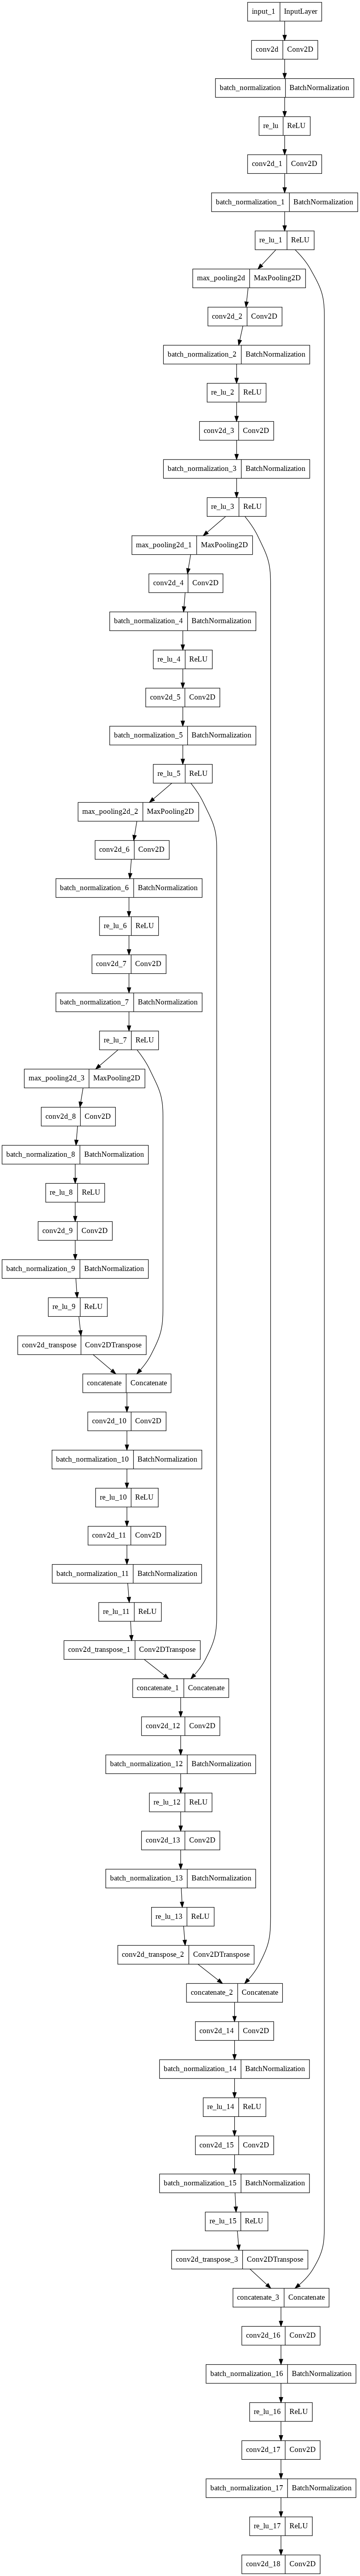

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

### Data importing and plotting the images

#### Import and sort the images

In [ ]:
## Import the images and annotations
import os

input_dir = r"C:/Users/Swata/Downloads/images/" # Enter the path of the images
target_dir = r"C:/Users/Swata/Downloads/annotations/trimaps/" # Enter the path of the annotations
img_size = (160, 160) # Enter the image size
num_classes = 3 # Enter the number of classes
batch_size = 8 # Enter the batch size

## get the file names and sort to have the corresponding image and masks in order
# Get the list of file paths for all the images
input_img_paths = sorted( 
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
# Get the list of file paths for all the corresponding annotations
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths)) # Print the number of samples

# check names of the first 10 image and mask pair
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
C:/Users/Swata/Downloads/images/Abyssinian_1.jpg | C:/Users/Swata/Downloads/annotations/trimaps/Abyssinian_1.png
C:/Users/Swata/Downloads/images/Abyssinian_10.jpg | C:/Users/Swata/Downloads/annotations/trimaps/Abyssinian_10.png
C:/Users/Swata/Downloads/images/Abyssinian_100.jpg | C:/Users/Swata/Downloads/annotations/trimaps/Abyssinian_100.png
C:/Users/Swata/Downloads/images/Abyssinian_101.jpg | C:/Users/Swata/Downloads/annotations/trimaps/Abyssinian_101.png
C:/Users/Swata/Downloads/images/Abyssinian_102.jpg | C:/Users/Swata/Downloads/annotations/trimaps/Abyssinian_102.png
C:/Users/Swata/Downloads/images/Abyssinian_103.jpg | C:/Users/Swata/Downloads/annotations/trimaps/Abyssinian_103.png
C:/Users/Swata/Downloads/images/Abyssinian_104.jpg | C:/Users/Swata/Downloads/annotations/trimaps/Abyssinian_104.png
C:/Users/Swata/Downloads/images/Abyssinian_105.jpg | C:/Users/Swata/Downloads/annotations/trimaps/Abyssinian_105.png
C:/Users/Swata/Downloads/images/Abyssinian_106

#### check the images and masks by plotting

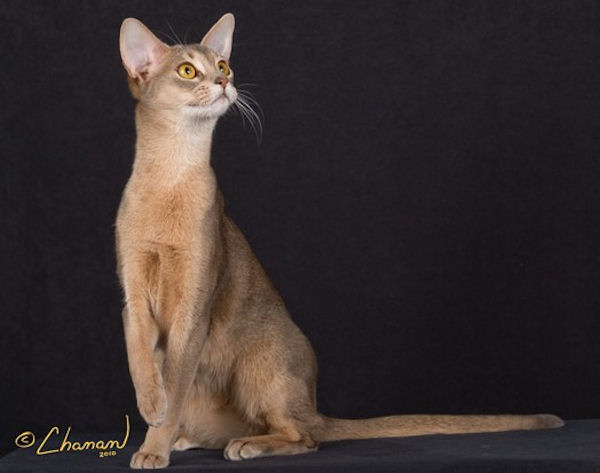

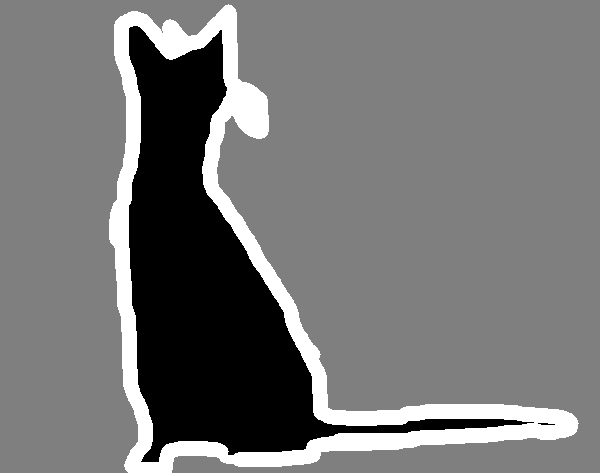

In [ ]:
# Display input image #7
display(Image(filename=input_img_paths[100]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[100]))
display(img)

### Process the images

#### Now we'll create a helper function to load the data

In [ ]:
# Create OxfordPets class to load & vectorize batches of data
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    # 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        
        self.batch_size = batch_size # Initialize the batch size
        self.img_size = img_size # Initialize the image size
        self.input_img_paths = input_img_paths # Initialize the input image paths
        self.target_img_paths = target_img_paths # Initialize the target image paths

    def __len__(self):
        
        return len(self.target_img_paths) // self.batch_size # Return the length of the target image paths

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size] # Get the input image paths
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] # Get the target image paths
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") # Initialize the input array
        
        for j, path in enumerate(batch_input_img_paths): # Iterate over the input image paths
            img = load_img(path, target_size=self.img_size)
            x[j] = img
       
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8") # Initialize the target array
        
        for j, path in enumerate(batch_target_img_paths): # Iterate over the target image paths
            img = load_img(path, target_size=self.img_size, color_mode="grayscale") # Load the image
            y[j] = np.expand_dims(img, 2) # Add the image to the target array
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

#### Split our img paths into a training and a validation set

In [ ]:
# Split our img paths into a training and a validation set
val_samples = 1000 # Enter the number of validation samples

# shuffle the training and testing examples
random.Random(1337).shuffle(input_img_paths) 
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


### Train the model

In [1]:
## compile and train the model
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

### Test the model

In [ ]:
## Generate predictions for all images in the validation set
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


In [ ]:
## create a function to plot masks
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

In [ ]:
# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

# THANK YOU